## MTCNN Face Detection Module Evaluation

In the following lines of code, the evaluation of the **MTCNN face detection model** is performed. The dataset used for this evaluation was manually created and labeled. Two folders were created: one named "face" and the other "no_face."

In the first folder, labeled "face," 3,000 images of human faces (one face per image) were collected. These images come from three different datasets to capture as much variation as possible: Labeled Faces in the Wild, MSU-MFSD Photos and NUAA Photograph Imposter Database. This diverse selection was made to test the model across different environments, lighting conditions and facial expressions.

In the "no_face" folder, another 3,000 images were collected, all of which contain no human faces. These images include a mix of animals (dogs, cats, lions, horses), various types of balls, and other round or oval objects that could potentially confuse a face detection model. The goal of this was to evaluate the robustness of the chosen model, as these objects might be mistakenly classified as human faces by less accurate models.

For the evaluation, various metrics were considered. The evaluation process involved calculating:
- **False positives**: images where the model incorrectly detected a face;
- **Missed faces**: images where the model failed to detect a face that was actually present;
- **True positives**: correctly detected faces;
- **True negatives**: correctly identified images with no faces.

Using these values, we could calculate two key metrics:
- **False Positive Rate (FPR)**: the proportion of non-face images that were incorrectly classified as containing faces.
- **Missed Face Rate (MFR)**: the proportion of face images where the model failed to detect a face.

In [1]:
import os
import torch
from facenet_pytorch import MTCNN
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import warnings
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore") 

batch_size = 16
data_dir = r'C:\Users\User\Desktop\Face_localization_dataset'
face_dir = os.path.join(data_dir, 'face')
no_face_dir = os.path.join(data_dir, 'no_face')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda


In [3]:
# MTCNN is a face detection model that finds faces in an image. It uses a cascaded architecture to improve face localization.
mtcnn = MTCNN(
    image_size=224,  # The target size of the face crops
    margin=14, # The margin adds a margin around the detected face to ensure the full face is captured
    device=device, # It specifies the device (CPU/GPU) where the model should run
    selection_method='center_weighted_size' # The selection_method specifies how to select faces when multiple faces are detected, prioritizing faces that are centrally located.
)

In [4]:
class FaceDataset(Dataset):
    def __init__(self, face_dir, no_face_dir, transform=None):
        self.face_dir = face_dir
        self.no_face_dir = no_face_dir
        self.transform = transform
        
        # Collect all face images and label them as 1 (face present)
        self.face_images = [(os.path.join(face_dir, img), 1) for img in os.listdir(face_dir)]
        
        # Collect all no-face images and label them as 0 (no face present)
        self.no_face_images = [(os.path.join(no_face_dir, img), 0) for img in os.listdir(no_face_dir)]

        # Combine both face and no-face images into a single list
        self.all_images = self.face_images + self.no_face_images

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [5]:
def show_random_images(dataset, num_images=10):
    face_images = [img for img in dataset.face_images] # Select images labeled as "face"
    no_face_images = [img for img in dataset.no_face_images] # Select images labeled as "no face"

    # Randomly select 10 face images
    selected_face_images = random.sample(face_images, num_images)

    # Randomly select 10 no-face images
    selected_no_face_images = random.sample(no_face_images, num_images)

    # Display face images
    print("Class: face (label = 1)")
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, (img_path, label) in enumerate(selected_face_images):
        img = Image.open(img_path)
        axs[i // 5, i % 5].imshow(img)
        axs[i // 5, i % 5].axis('off')
        axs[i // 5, i % 5].set_title(f"Label: {label}")
    plt.show()

    # Display no face images
    print("Class: no_face (label = 0)")
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, (img_path, label) in enumerate(selected_no_face_images):
        img = Image.open(img_path)
        axs[i // 5, i % 5].imshow(img)
        axs[i // 5, i % 5].axis('off')
        axs[i // 5, i % 5].set_title(f"Label: {label}")
    plt.show()

In [6]:
transform = transforms.Compose([transforms.Resize((224, 224))])

dataset = FaceDataset(face_dir=face_dir, no_face_dir=no_face_dir, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

Class: face (label = 1)


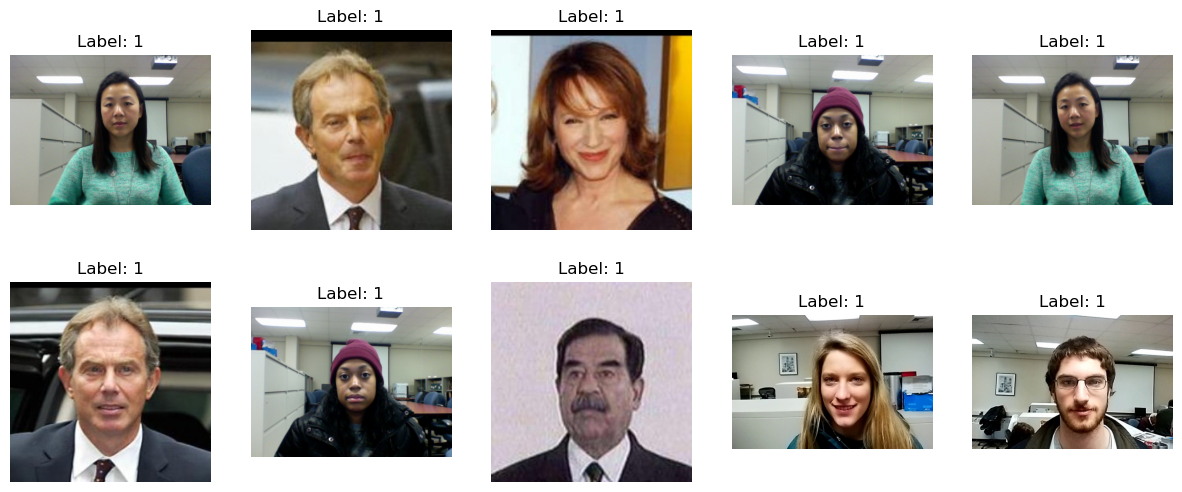

Class: no_face (label = 0)


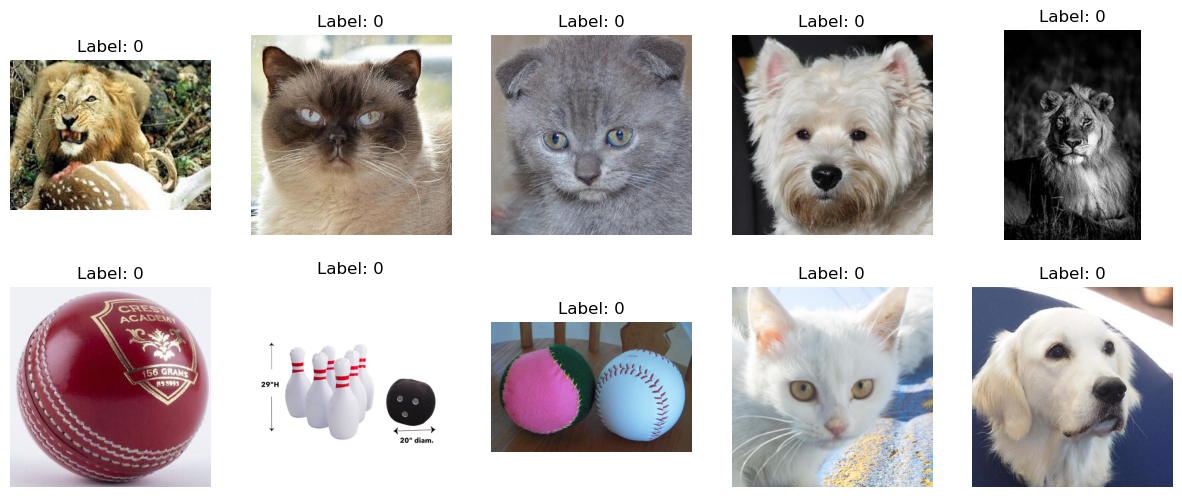

In [30]:
show_random_images(dataset)

In [8]:
def plot_confusion_matrix(false_positives, missed_faces, true_positive, true_negative):
    # Create the confusion matrix
    cm = np.array([[true_negative, false_positives],
                   [missed_faces, true_positive]])

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Face', 'Face'])
    
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
false_positives = 0
missed_faces = 0
true_positive = 0
true_negative = 0
total_no_faces = 3000
total_faces = 3000

for batch in tqdm(loader, desc="Processing batches"):
    for img, label in batch:
        boxes, _ = mtcnn.detect(img) # Use the MTCNN model to detect faces in the image

        if boxes is None: # No face detected
            if label == 1: # If there should be a face (label == 1), it's a missed detection
                missed_faces += 1
            else: # If no face should be present (label == 0), it's a true negative
                true_negative += 1
        else: # Face detected
            if label == 0: # If there should be no face (label == 0), it's a false positive
                false_positives += 1
            else: # Correctly detected face
                true_positive += 1

false_positive_rate = false_positives / total_no_faces if total_no_faces > 0 else 0
missed_face_rate = missed_faces / total_faces if total_faces > 0 else 0

print(f'False Positive Rate: {false_positive_rate * 100:.2f}%')
print(f'Missed Face Rate: {missed_face_rate * 100:.2f}%')

Processing batches: 100%|████████████████████████████████████████████████████████████| 375/375 [16:21<00:00,  2.62s/it]

False Positive Rate: 2.47%
Missed Face Rate: 0.00%


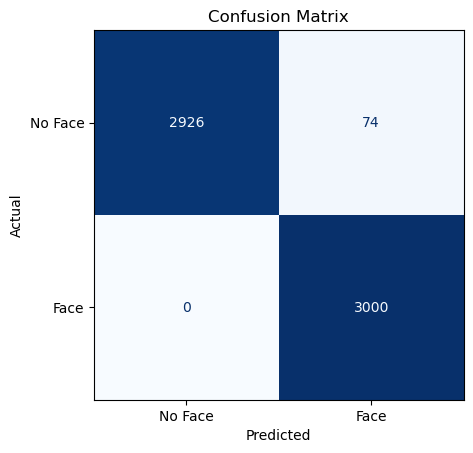

In [10]:
plot_confusion_matrix(false_positives, missed_faces, true_positive, true_negative)